# Traveling Salesman Problem

In [1]:
import numpy as np 
import pandas as pd 
import pulp 
import itertools
import gmaps
import googlemaps
import ortools
import matplotlib.pyplot as plt

In [55]:
from key import GAPI


In [56]:
gmaps.configure(api_key=GAPI)
from googlemaps import Client
client = Client(key=GAPI)

>Set parameters and simulate data

In [23]:
np.random.seed(12345)
customers = 15
wh_lat = 40.749587
wh_lon = -73.985441
locs = pd.DataFrame(dict(
    latitude = np.random.normal(wh_lat, .008, customers), 
    longitude = np.random.normal(wh_lon, .008, customers)
))

In [24]:
cols = ['latitude', 'longitude']

In [25]:
wh = pd.DataFrame([[wh_lat, wh_lon]], columns=cols)

In [26]:
data = pd.concat([wh, locs])

In [27]:
data.reset_index(inplace=True)

In [28]:
data.drop(['index'], axis=1, inplace=True)

In [29]:
data.head()

latitude  longitude
0  40.749587 -73.985441
1  40.747949 -73.978350
2  40.753419 -74.001454
3  40.745431 -73.988416
4  40.745141 -73.972089

>Add labels and colors to dataframe

In [30]:
data.reset_index(inplace=True)
data.rename(columns={'index':'Label'}, inplace=True)
data['Label'] = data.Label.astype(str)

In [31]:
data.at[0, 'Label'] = 'Warehouse'

In [32]:
data['colors'] = np.where(
    data.Label == 'Warehouse', 
    "darkslateblue", 
    "forestgreen"
)

In [33]:
import geopandas as gpd 
import contextily as ctx

In [34]:
data_gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(
        data.longitude, data.latitude
    ), crs=4326
)

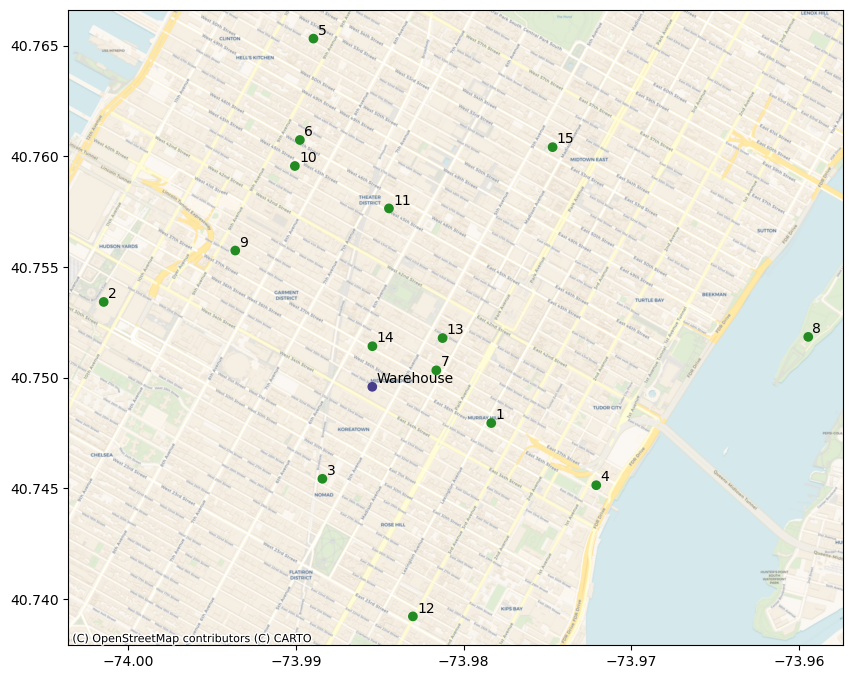

In [35]:
f, ax = plt.subplots(figsize=(10,10))
data_gdf.plot(ax=ax, color=data_gdf['colors'])
ctx.add_basemap(ax, crs=data_gdf.crs, 
               source=ctx.providers.CartoDB.Voyager, 
               zoom=16)
for x, y, label in zip(data_gdf.geometry.x, 
                       data_gdf.geometry.y, 
                       data_gdf.Label): 
    ax.annotate(label, 
                xy=(x,y), 
                xytext=(3,3), 
                textcoords='offset points');

>Use Google Maps Directions API to produce an O-D Cost Matrix

In [36]:
import sys
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=1000)

In [37]:
distances = np.zeros((len(data_gdf), 
                     len(data_gdf)))
data_gdf['coord'] = 'O'
for row in range(len(data_gdf)): 
    data_gdf.at[row, 'coord'] = (str(data_gdf.latitude[row]) + 
                                 "," + 
                                str(data_gdf.longitude[row]))

In [60]:
for lat in range(len(data_gdf)):
    for lon in range(len(data_gdf)):
        maps_api_result = client.directions(data_gdf['coord'].iloc[lat], 
                                       data_gdf['coord'].iloc[lon], 
                                       mode='driving')
        distances[lat][lon] = maps_api_result[0]['legs'][0]['distance']['value'] 

In [63]:
dist_int = distances.astype(int)
print(np.matrix(dist_int))

[[    0  1306  2023  1482  1672  2813  2133   842  8997  1473  1728  1157  2189   949  1025  2095]
 [  714     0  2738  1306   677  3695  2849  1101  8002  2356  2447  1875  1194  1544   969  2759]
 [ 3167  3388     0  2222  3752  2700  2410  2924 11383  1749  2717  3240  3386  3031  3107  4174]
 [ 1119  1498  2652     0  1860  3781  3490  1505  9188  2829  2698  2127  1143  1918  1373  2755]
 [ 1491  1090  3518  2082     0  4307  3615  1879  8075  2967  3230  2658  1987  2643  1745  3130]
 [ 2709  2929  2471  3043  3612     0   662  2465  9224  1291  1287  1809  4203  2258  2649  1474]
 [ 2048  2267  2522  2365  2947  1390     0  1805  9516  1339  1017  1610  3461  1595  1988  1766]
 [  714   464  2741  1304  1141  2896  2218     0  8459  1558  1817  1245  1659   913   654  1721]
 [ 8685  8028 10772  9333  8215  9793  9752  8814     0  9902 10161  9590  9242  9257  8683  7979]
 [ 1410  1631  1887  1727  2308  2043  1364  1167  9626     0   959  1483  2826  1274  1350  2420]
 [ 2194  2

>Write the optimization problem

In [64]:
tsp_problem = pulp.LpProblem('tsp_mip', pulp.LpMinimize)

In [65]:
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(customers+1) 
                               for j in range(customers+1)),
                         lowBound=0, upBound=1, cat='Binary')

>Track order of points

In [66]:
u = pulp.LpVariable.dicts('u', 
                         (i for i in range(customers+1)), 
                         lowBound=1, upBound=(customers+1), cat='Integer')

>The objective function

In [67]:
tsp_problem += pulp.lpSum(
    dist_int[i][j] * x[i,j] 
    for i in range(customers+1)
    for j in range(customers+1)
)

>Program the constraints

In [68]:
for i in range(customers+1): 
    tsp_problem += x[i,i] == 0

In [69]:
for i in range(customers+1): 
    tsp_problem += pulp.lpSum(x[i,j] for j in range(customers+1)) == 1
    tsp_problem += pulp.lpSum(x[j,i] for j in range(customers+1)) == 1

>Eliminate possibility of subtour (Constraint 3)

In [70]:
for i in range(customers+1): 
    for j in range(customers+1): 
        if i != j and (i != 0 and j != 0): 
            tsp_problem += u[i] - u[j] <= (customers+1) * (1-x[i,j]) - 1

>Solve the TSP

In [ ]:
status = tsp_problem.solve()

In [72]:
status, pulp.LpStatus[status], pulp.value(tsp_problem.objective)

(1, 'Optimal', 31815.0)

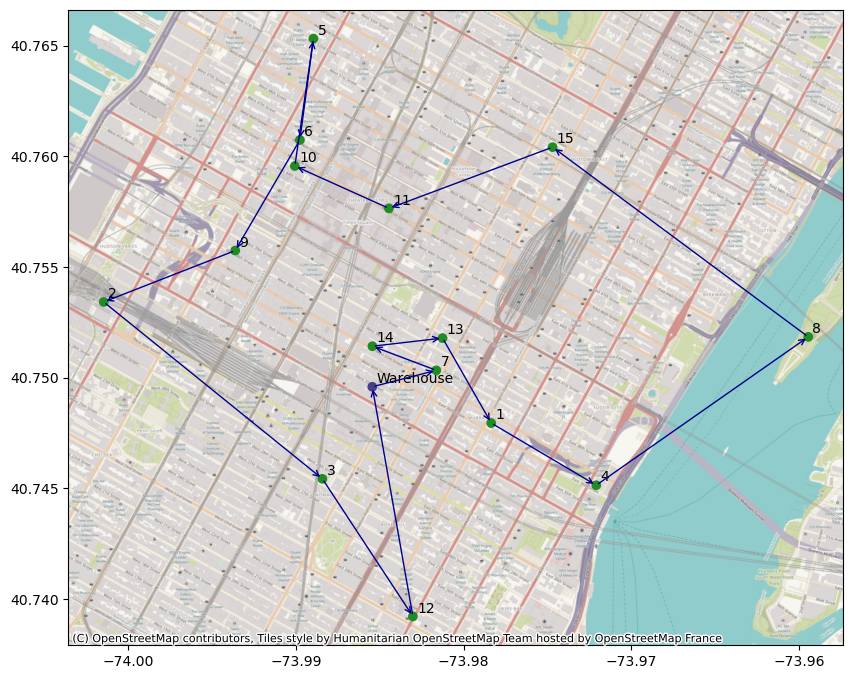

In [86]:
f, ax = plt.subplots(figsize=(10,10))
data_gdf.plot(ax=ax, color=data_gdf['colors'])
ctx.add_basemap(ax, crs=data_gdf.crs, 
                source=ctx.providers.OpenStreetMap.HOT, zoom=16)
for lon, lat, label in zip(data_gdf.geometry.x, 
                           data_gdf.geometry.y, 
                          data_gdf.Label): 
    ax.annotate(label, xy=(lon,lat), 
                xytext=(3,3), 
                textcoords='offset points')

routes = [(i, j) 
          for i in range(customers+1) 
          for j in range(customers+1) 
          if pulp.value(x[i, j]) == 1]

arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='darkblue')

for i, j in routes:
    ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, 
                        data_gdf.iloc[j].geometry.y], 
                xytext=[data_gdf.iloc[i].geometry.x, 
                        data_gdf.iloc[i].geometry.y], 
                arrowprops=arrowprops)

plt.show()

## Single-vehicle Vehicle Routing Problem 

Like above. This time use the alternative DFJ formulation.

>Simulate demand and vehicles

In [87]:
vehicles = 1
demand = np.random.randint(2, 12, customers).tolist()
demand = [0] + demand
data_gdf['customer_demand'] = demand

>Set up the problem by adding a dimension $k$ for the vehicles being used.

In [92]:
# Setting up the PuLP Solver
for vehicles in range(1, vehicles+1):
    
    # Linear Programming Problem
    lp_problem = pulp.LpProblem("VRP", pulp.LpMinimize)
    
    # Defining problem variables which are binary
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None 
           for k in range(vehicles)] 
          for j in range(customers+1)] 
         for i in range(customers+1)]
    
    # Setting the objective function
    lp_problem += pulp.lpSum(dist_int[i][j] * x[i][j][k] if i != j else 0
                             for k in range(vehicles)
                             for j in range(customers+1)
                             for i in range(customers+1))
    
    # Adding in the constraints
    for j in range (1, customers+1):
        lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i in range(customers+1) for k in range(vehicles)) == 1
    
    for k in range(vehicles):
        lp_problem += pulp.lpSum(x[0][j][k] for j in range(1, customers+1)) == 1
        lp_problem += pulp.lpSum(x[i][0][k] for i in range(1, customers+1)) == 1
    
    for k in range(vehicles):
        for j in range(customers+1):
            lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(customers+1)) - pulp.lpSum(x[j][i][k] for i in range(customers+1)) == 0
    
    # Adding additional constraint to prevent subtours. We'll use DFJ formulation here.
    subtours = []
    for i in range(2, customers+1):
        subtours += itertools.combinations(range(1, customers+1), i)
    for s in subtours:
        lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicles)) <= len(s) -1

    if lp_problem.solve() == 1:
        print('# Required Vehicles:',vehicles)
        print('Distance:',pulp.value(lp_problem.objective))
        break

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/biscotty/Learning/AppliedGeospatial/_build/pip_packages/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8022d5b05b3e44638f9db7d3e3abf0a2-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/8022d5b05b3e44638f9db7d3e3abf0a2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 32790 COLUMNS
At line 1754566 RHS
At line 1787352 BOUNDS
At line 1787593 ENDATA
Problem MODEL has 32785 rows, 240 columns and 1721055 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 31815 - 0.24 seconds
Cgl0004I processed model has 32785 rows, 240 columns (240 integer (240 of which binary)) and 1721055 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 31815
Cbc0038I Before mini branch and bound,

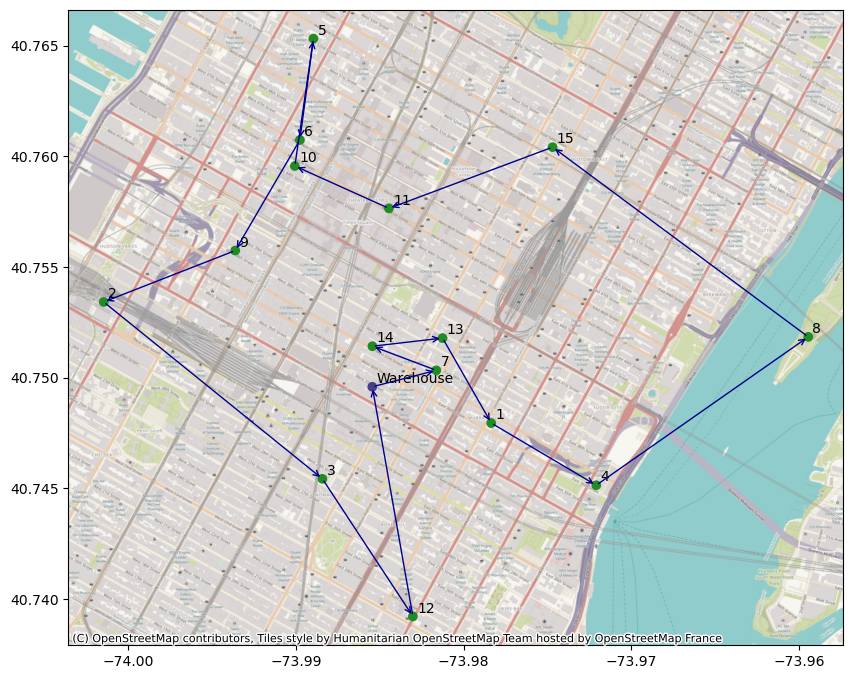

In [93]:
f, ax = plt.subplots(1, figsize=(10, 10))

data_gdf.plot(ax=ax,color=data_gdf['colors'])
        
# Add basemap
ctx.add_basemap(
    ax,
    crs=data_gdf.crs,
    source=ctx.providers.OpenStreetMap.HOT,
    zoom=16
)

for lon, lat, label in zip(data_gdf.geometry.x, data_gdf.geometry.y, data_gdf.Label):
    ax.annotate(label, xy=(lon, lat), xytext=(3, 3), textcoords="offset points")


# Plot the optimal route between stops
routes = [(k, i, j) for k in range(vehicles) for i in range(customers+1) for j in range(customers+1) if i != j and pulp.value(x[i][j][k]) == 1]

arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='darkblue')

for k, i, j in routes:
    ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, data_gdf.iloc[j].geometry.y], xytext=[data_gdf.iloc[i].geometry.x, data_gdf.iloc[i].geometry.y], arrowprops=arrowprops)

plt.show()

>The same result as the other method. Now calculate demand

## Capacitated Vehicle Routing Problem (CVRP)

In [112]:
vehicles = 5
demand = np.random.randint(2, 12, customers).tolist()
demand = [0] + demand
data_gdf['customer_demand'] = demand
data_gdf.customer_demand.sum()

90

In [113]:
capacity = 40

In [114]:
for vehicles in range(1, vehicles+1): 
    # Linear programming problem 
    lp_problem = pulp.LpProblem('CVRP', pulp.LpMinimize)
    # Define problem variables which are binary 
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat='Binary') 
          if i != j else None 
            for k in range(vehicles)]
         for j in range(customers+1)] 
        for i in range(customers+1)]
    # Set the objective function 
    lp_problem += pulp.lpSum(dist_int[i][k] * x[i][j][k] 
                            if i != j else 0 
                            for k in range(vehicles) 
                            for j in range(customers+1) 
                            for i in range(customers+1))
    # Add the constraints
    for j in range (1, customers+1):
        lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i in range(customers+1) for k in range(vehicles)) == 1
    
    for k in range(vehicles):
        lp_problem += pulp.lpSum(x[0][j][k] for j in range(1, customers+1)) == 1
        lp_problem += pulp.lpSum(x[i][0][k] for i in range(1, customers+1)) == 1
    
    for k in range(vehicles):
        for j in range(customers+1):
            lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                 for i in range(customers+1)) - pulp.lpSum(x[j][i][k] for i in range(customers+1)) == 0

    # Adding in the capacity constraint
    for k in range(vehicles):
        lp_problem += pulp.lpSum(data_gdf.customer_demand[j] * x[i][j][k] if i != j else 0 for i in range(customers+1) for j in range (1,customers+1)) <= capacity
    
    # Adding additional constraint to prevent subtours. We'll use DFJ formulation here.
    subtours = []
    for i in range(2, customers+1):
        subtours += itertools.combinations(range(1, customers+1), i)
    for s in subtours:
        lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicles)) <= len(s) -1

    if lp_problem.solve() == 1:
        print('# Required Vehicles:',vehicles)
        print('Distance:',pulp.value(lp_problem.objective))
        break



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/biscotty/Learning/AppliedGeospatial/_build/pip_packages/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/f0e403998b4545d4b098dfa3cd78ecf1-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/f0e403998b4545d4b098dfa3cd78ecf1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 32791 COLUMNS
At line 1754777 RHS
At line 1787564 BOUNDS
At line 1787805 ENDATA
Problem MODEL has 32786 rows, 240 columns and 1721280 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.28 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.59   (Wallclock seconds):       0.64

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/biscotty/Learning/AppliedGeospatial/_build/pip_packages/lib/python3.12/site-p

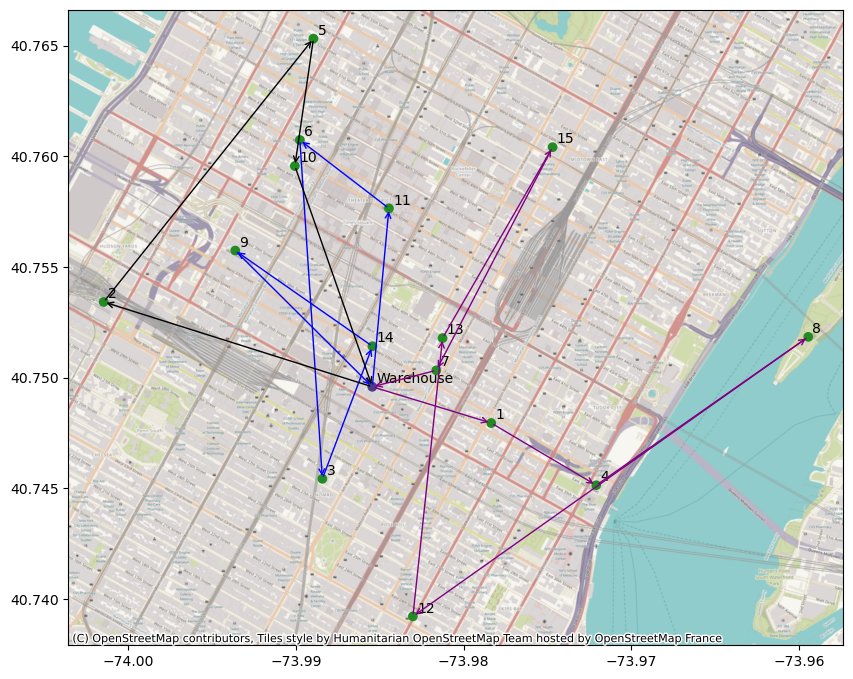

In [115]:
f, ax = plt.subplots(1, figsize=(10, 10))

data_gdf.plot(ax=ax,color=data_gdf['colors'])
        
# Add basemap
ctx.add_basemap(
    ax,
    crs=data_gdf.crs,
    source=ctx.providers.OpenStreetMap.HOT,
    zoom=16
)

for lon, lat, label in zip(data_gdf.geometry.x, data_gdf.geometry.y, data_gdf.Label):
    ax.annotate(label, xy=(lon, lat), xytext=(3, 3), textcoords="offset points")

# Plot the optimal route between stops
routes = [(k, i, j) for k in range(vehicles) for i in range(customers+1) for j in range(customers+1) if i != j and pulp.value(x[i][j][k]) == 1]

for k, i, j in routes:
    if k == 0:
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
        ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, data_gdf.iloc[j].geometry.y], xytext=[data_gdf.iloc[i].geometry.x, data_gdf.iloc[i].geometry.y], arrowprops=arrowprops)
    elif k==1:
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='purple')
        ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, data_gdf.iloc[j].geometry.y], xytext=[data_gdf.iloc[i].geometry.x, data_gdf.iloc[i].geometry.y], arrowprops=arrowprops)
    else:
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='black')
        ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, data_gdf.iloc[j].geometry.y], xytext=[data_gdf.iloc[i].geometry.x, data_gdf.iloc[i].geometry.y], arrowprops=arrowprops)
         
# Display the plot       
plt.show()